In [12]:
import tequila as tq
import random
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def HP(qubits,param,graph):
    ham = tq.QubitHamiltonian() 
    for k in range(len(graph)):
        ham -= param[k]*0.5*(1-tq.paulis.Z(graph[k][0])*tq.paulis.Z(graph[k][1]))
    return(ham)

def exact(ham):
    ham_matrix = ham.to_matrix()
    energ = np.linalg.eigvals(ham_matrix)
    return(min(energ))

def exact_state(ham):
    ham_matrix = ham.to_matrix()
    eigenValues, eigenVectors = np.linalg.eig(ham_matrix)
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return(eigenValues,eigenVectors)
    

# commuting
def HP_str(q1,q2):
    ham_prob = "Z({})Z({})".format(q1,q2)
    return ham_prob

# commuting
def HM_str(q1):
    ham_mix = "X({})".format(q1)
    return ham_mix

def QAOA_circuit(qubits,layers,graph):
    
    circuit = tq.QCircuit()
    
    #init state
    circuit += tq.gates.H(range(qubits))
    
    for l in range(layers):
        beta = tq.Variable(name="beta{}".format(l))
        gamma = tq.Variable(name="gamma{}".format(l)) 
        for k in range(qubits):
            circuit += tq.gates.ExpPauli(angle=beta, paulistring=HM_str(k))
        for k in range(len(graph)):
            circuit += tq.gates.ExpPauli(angle=gamma, paulistring=HP_str(graph[k][0],graph[k][1]))
    
    return circuit

# VQE hardware-efficient
def VQE_HE(qubits,layers):
    
    circuit = tq.QCircuit()
    
    for l in range(layers):
        for i in range(qubits-1):
            th = tq.Variable(name="th{}{}".format(i,l))
            circuit += tq.gates.Ry(target=i, angle=th)
        # Layer alternating CNOTs
        ent0 = np.mod(l, 2)
        for ent in range(ent0, qubits - 1, 2):
            circuit += tq.gates.CNOT(control=ent, target=ent + 1)
    
    return circuit


In [94]:
qubits = 4
lay_max = 3

# Optimizer options
methods = 'COBYLA'
grad_methods = '2-point'
backend = 'qulacs'
lr = 0.01
# make sure scipy version is >= 1.5
mthd_opt = {'finite_diff_rel_step': 0.0001}


graph = [[0, 1], [0, 3], [1, 2], [2, 3]]

param = [random.uniform(0,1) for i in range(len(graph))]

#param = [1 for i in range(len(graph))]

print("parameters = ", param)
print("exact = ", exact(HP(qubits,param,graph)))
#print("exact states = ", exact_state(HP(qubits,param,graph)))

energ_QAOA = []
energ_VQE = []
param_QAOA=[]
param_VQE=[]

for layers in range(1,2*lay_max):
    
    Obj_QAOA = tq.ExpectationValue(H=HP(qubits,param,graph), U=QAOA_circuit(qubits,layers,graph))
    var_QAOA = Obj_QAOA.extract_variables()
    # Random initialization of variables
    var0 = {key: random.uniform(0, np.pi) for key in var_QAOA}
    initial_values = var0
    QAOA = tq.minimize(objective=Obj_QAOA, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods, samples=None,
                          initial_values=initial_values, backend=backend, noise=None, device=None, silent=True)      
    
    energ_QAOA.append(QAOA.energy)
    param_QAOA.append(len(var_QAOA))
    
    print(f"QAOA) {layers} layers ({len(var_QAOA)} parameters): {QAOA.energy}")

wfn = tq.simulate(QAOA_circuit(qubits,layers,graph), samples=100, variables=QAOA.angles, backend=backend)
print(wfn)

for layers in range(1,lay_max+1):
    Obj_VQE = tq.ExpectationValue(H=HP(qubits,param,graph), U=VQE_HE(qubits,layers))
    var_VQE = Obj_VQE.extract_variables()
    # Random initialization of variables
    var0 = {key: random.uniform(0, np.pi) for key in var_VQE}
    initial_values = var0
    VQE = tq.minimize(objective=Obj_VQE, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods, samples=None,
                          initial_values=initial_values, backend=backend, noise=None, device=None, silent=True)      
    energ_VQE.append(VQE.energy)
    param_VQE.append(len(var_VQE))
    
    
    print(f"VQE) {layers} layers ({len(var_VQE)} parameters): {VQE.energy}")
    
    #wfn = tq.simulate(VQE_HE(qubits,layers), variables=VQE.angles)
    #print(wfn)
wfn = tq.simulate(VQE_HE(qubits,layers), samples=100, variables=VQE.angles, backend=backend)
print(wfn)

parameters =  [0.7052182528768369, 0.16010323030295082, 0.6757157095308177, 0.853424735167381]
exact =  (-2.3944619278779866+0j)
QAOA) 1 layers (2 parameters): -1.1972309639389933
QAOA) 2 layers (4 parameters): -1.7958461377320352
QAOA) 3 layers (6 parameters): -2.394458886537584
QAOA) 4 layers (8 parameters): -2.3944602476340844
QAOA) 5 layers (10 parameters): -2.3944537868431555
+45.0000|0101> +55.0000|1010> 
VQE) 1 layers (3 parameters): -1.3809339315372884
VQE) 2 layers (6 parameters): -2.394461483037278
VQE) 3 layers (9 parameters): -2.3939382957565196
+100.0000|1010> 


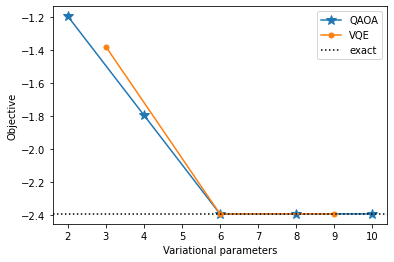

In [95]:
plt.plot(param_QAOA,energ_QAOA, marker="*", markersize=10,label="QAOA")
plt.plot(param_VQE,energ_VQE,marker=".",markersize=10,label="VQE")
plt.axhline(exact(HP(qubits,param,graph)), color="black", linestyle=":", label="exact")
plt.xlabel("Variational parameters")
plt.ylabel("Objective")
plt.legend()
plt.show()